## Metrics

In [1]:
import numpy as np
import string
import re
from collections import Counter
import re


def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def handle_punc(text):
        exclude = set(string.punctuation + "".join([u"‘", u"’", u"´", u"`"]))
        return ''.join(ch if ch not in exclude else ' ' for ch in text)

    def lower(text):
        return text.lower()

    def replace_underscore(text):
        return text.replace('_', ' ')

    return white_space_fix(remove_articles(handle_punc(lower(replace_underscore(s))))).strip()


def f1_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    return normalize_answer(prediction) == normalize_answer(ground_truth)


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    metric_fn: fns that take two strs only
    pred: str
    gts: list(str)
    '''
    if type(ground_truths) == str:
        ground_truths = [ground_truths]
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


# def accuracy(preds, labels):
#     match_count = 0
#     for pred, label in zip(preds, labels):
#         target = label[0]
#         if pred == target:
#             match_count += 1

#     return 100 * (match_count / len(preds))

# def accuracy(pred, label):
#     '''
#     akari claimed acc
#     ===
#     pred: str
#     label: str or list(str)
#     '''
#     if type(label) == list:
#         assert len(label) == 1
#         label = label[0]

#     return pred.lower()==label.lower()

def loose_acc(pred, label):
    '''
    pred: str
    label: str
    '''
    cnt = 0
    pred = normalize_answer(pred)
    label = normalize_answer(label)
    if len(pred) == 0:
        return 0
    if pred.startswith(label):
        cnt += len(label)

    return cnt / len(pred)


def loose_match(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    if ground_truth in prediction:
        return 1
    return 0

## Json to Pandas DataFrame

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple, Literal



In [3]:
{**{}, **{1:1}}

{1: 1}

In [4]:
def try_load_or_save_ret_p(json_path: str, ret_p: None):
    if 'pqa' in json_path:
        file_name = 'pqa.json'
    elif 'tqa' in json_path:
        file_name = 'tqa.json'
    elif 'arc' in json_path:
        file_name = 'arc.json'
    else:
        file_name = 'health.json'
        
    if ret_p is not None:
        with open(file_name, 'w') as f:
            json.dump(ret_p, f)
    else:
        with open(file_name, 'r') as f:
            ret_p = json.load(f)
    return ret_p

In [5]:
class Analyzer:
    def __init__(self, json_path):
        self.df, self.df_dict = self.json2df(json_path)
        self.json_path = json_path
        self.metric_evaluation()


    def json2df(self, json_path):
        with open(json_path) as f:
            json_file = json.load(f)
            
        no_retrievals = {"no_retrieval": [i["no_retrieval"] for i in json_file['results']]}
        all_doc_retrieval = {"all_doc_retrieval": [i["all_doc_retrieval"] for i in json_file['results']]}
        top_doc_retrieval = {"top_doc_retrieval": [i['retrieval'] for i in json_file['results']]}
        try:
        
            retrieval_p = {"retrieval_p": [i['retrieval_p'] for i in json_file['results']]}
            if "minqi" not in json_path:
                try_load_or_save_ret_p(json_path, retrieval_p)
        except:
            
            retrieval_p = {"retrieval_p": [0.5]*len(json_file['results'])}
        
        
        if 'no_retrieval_log_probs' in json_file['results'][0]:
            no_retrievals_logprobs = {"no_retrieval_logprobs": [i["no_retrieval_log_probs"] for i in json_file['results']]}
            all_doc_retrieval_logprobs = {"all_doc_retrieval_logprobs": [i["all_doc_retrieval_log_probs"] for i in json_file['results']]}
            top_doc_retrieval_logprobs = {"top_doc_retrieval_logprobs": [i['retrieval_log_probs'] for i in json_file['results']]}

            no_retrievals_avg_confidence = {"no_retrieval_avg_confidence": [np.mean(np.exp(i["no_retrieval_log_probs"])) for i in json_file['results']]}
            all_doc_retrieval_avg_confidence = {"all_doc_retrieval_avg_confidence": [np.mean(np.exp(i["all_doc_retrieval_log_probs"])) for i in json_file['results']]}
            top_doc_retrieval_avg_confidence = {"top_doc_retrieval_avg_confidence": [np.mean(np.exp(i['retrieval_log_probs'])) for i in json_file['results']]}
            print(top_doc_retrieval_avg_confidence)
        
            no_retrievals_inv_perplexity = {"no_retrieval_inv_perplexity": [np.exp(np.mean(i["no_retrieval_log_probs"])) for i in json_file['results']]}
            all_doc_retrieval_inv_perplexity = {"all_doc_retrieval_inv_perplexity": [np.exp(np.mean(i["all_doc_retrieval_log_probs"])) for i in json_file['results']]}
            top_doc_retrieval_inv_perplexity = {"top_doc_retrieval_inv_perplexity": [np.exp(np.mean(i['retrieval_log_probs'])) for i in json_file['results']]}
            print(top_doc_retrieval_inv_perplexity)
        
        
        else:
            no_retrievals_logprobs = {}
            all_doc_retrieval_logprobs = {}
            top_doc_retrieval_logprobs = {}
            no_retrievals_avg_confidence = {}
            all_doc_retrieval_avg_confidence = {}
            top_doc_retrieval_avg_confidence = {}
            no_retrievals_inv_perplexity = {}
            all_doc_retrieval_inv_perplexity = {}
            top_doc_retrieval_inv_perplexity = {}
        
        gold = {"gold": [i['gold'] for i in json_file['results']]}

        loose_match_no_ret = {"loose_match_no_ret": [metric_max_over_ground_truths(loose_match, i["no_retrieval"], i['gold']) for i in json_file['results']]}
        loose_match_ret_all = {"loose_match_ret_all": [metric_max_over_ground_truths(loose_match, i["all_doc_retrieval"], i['gold']) for i in json_file['results']]}
        loose_match_ret_top = {"loose_match_ret_top": [metric_max_over_ground_truths(loose_match, i['retrieval'], i['gold']) for i in json_file['results']]}

        em_no_ret = {"em_no_ret": [metric_max_over_ground_truths(exact_match_score, i["no_retrieval"], i['gold']) for i in json_file['results']]}
        em_ret_all = {"em_ret_all": [metric_max_over_ground_truths(exact_match_score, i["all_doc_retrieval"], i['gold']) for i in json_file['results']]}
        em_ret_top = {"em_ret_top": [metric_max_over_ground_truths(exact_match_score, i['retrieval'], i['gold']) for i in json_file['results']]}

        f1_no_ret = {"f1_no_ret": [metric_max_over_ground_truths(f1_score, i["no_retrieval"], i['gold']) for i in json_file['results']]}
        f1_ret_all = {"f1_ret_all": [metric_max_over_ground_truths(f1_score, i["all_doc_retrieval"], i['gold']) for i in json_file['results']]}
        f1_ret_top = {"f1_ret_top": [metric_max_over_ground_truths(f1_score, i['retrieval'], i['gold']) for i in json_file['results']]}


        loose_acc_no_ret = {"loose_acc_no_ret": [metric_max_over_ground_truths(loose_acc, i["no_retrieval"], i['gold']) for i in json_file['results']]}
        loose_acc_ret_all = {"loose_acc_ret_all": [metric_max_over_ground_truths(loose_acc, i["all_doc_retrieval"], i['gold']) for i in json_file['results']]}
        loose_acc_ret_top = {"loose_acc_ret_top": [metric_max_over_ground_truths(loose_acc, i['retrieval'], i['gold']) for i in json_file['results']]}


        df_dict = {**no_retrievals, **all_doc_retrieval, **top_doc_retrieval, **no_retrievals_logprobs, **all_doc_retrieval_logprobs, \
            **no_retrievals_avg_confidence, **all_doc_retrieval_avg_confidence, **top_doc_retrieval_avg_confidence, \
            **no_retrievals_inv_perplexity, **all_doc_retrieval_inv_perplexity, **top_doc_retrieval_inv_perplexity, \
            **top_doc_retrieval_logprobs, **retrieval_p, **gold, **loose_match_no_ret, **loose_match_ret_all, **loose_match_ret_top, **em_no_ret, **em_ret_all, **em_ret_top, **f1_no_ret, **f1_ret_all, **f1_ret_top, **loose_acc_no_ret, **loose_acc_ret_all, **loose_acc_ret_top}
        df = pd.DataFrame(df_dict)
        return df, df_dict
    
    def metric_evaluation(self, metrics = ['loose_match', 'em', 'f1', 'loose_acc'], retrieval_methods = ['no_ret', 'ret_all', 'ret_top'], threshold:float=0.2):
        '''
        metric: str
        retrieval_method: str
        threshold: float
        '''
        for method in retrieval_methods:
            print(f"=== {method} ===")
        
            if method == 'no_ret':
                print(f"Total number of samples: {len(self.df)}")
                for metric in metrics:
                    print(f"{metric}: {self.df[f'{metric}_{method}'].mean()}")
            else:
                print(f"Threshold: {threshold}")
                print(f"Total number of samples: {len(self.df)}")
                print(f"Number of samples with retrieval probability > {threshold}: {len(self.df[self.df['retrieval_p'] > threshold])}")
                print(f"Number of samples with retrieval probability <= {threshold}: {len(self.df[self.df['retrieval_p'] <= threshold])}")
                print(f"Retrieval frequency: {len(self.df[self.df['retrieval_p'] > threshold])/len(self.df)}")
                
                for metric in metrics:
                    print(f"{metric}_all_ret: {self.df[f'{metric}_{method}'].mean()}")
                    print(f"{metric}_adp_ret: {(self.df[self.df['retrieval_p'] > threshold][f'{metric}_{method}'].sum() + self.df[self.df['retrieval_p'] <= threshold][f'{metric}_no_ret'].sum())/len(self.df)}")
        
    
    def retrieve_p_distribution(self):
        return sns.histplot(self.df['retrieval_p'], kde=True)
    
    
    def compare_retrieval_methods_by_metrics(self):
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']
        METHOD_SUFFIX = {'no_retrieval':'no_ret', 'all_doc_retrieval': 'ret_all', 'top_doc_retrieval':'ret_top'}
        METHODS = ['no_retrieval', 'all_doc_retrieval', 'top_doc_retrieval']

        dc_metrics = {"metric":[], "mean":[], "retrieval method":[]}

        for row_dict in self.df.to_dict(orient="records"):

            for method in METHODS:
                for metric in METRICS:
                    dc_metrics["mean"].append(row_dict[f"{metric}_{METHOD_SUFFIX[method]}"])
                    dc_metrics["metric"].append(metric)
                    dc_metrics["retrieval method"].append(method)
        return sns.catplot(data=pd.DataFrame(dc_metrics), x="retrieval method", y="mean", hue="metric", kind="point")     
        
    def metrics_varying_threshold(self, interval=0.01, ret_method:Literal['no_ret', 'ret_all', 'ret_top']='ret_top'):
        '''
        metric: str
        threshold: str
        '''
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']
        METHOD_SUFFIX = {'no_retrieval':'no_ret', 'all_doc_retrieval': 'ret_all', 'top_doc_retrieval':'ret_top'}
        METHODS = ['no_retrieval', 'all_doc_retrieval', 'top_doc_retrieval']

        df_thres = {"retrieval threshold":[], "metrics":[], "mean":[]}
        for thres in [interval*i for i in range(0, int(1/interval)+1)]:
            
            for metric in METRICS:
                df_thres["retrieval threshold"].append(thres)
                metric_mean = self.df[self.df['retrieval_p'] > thres][f'{metric}_{ret_method}'].sum() + self.df[self.df['retrieval_p'] <= thres][f'{metric}_no_ret'].sum()
                metric_mean /= len(self.df)
                df_thres["metrics"].append(metric)
                df_thres["mean"].append(metric_mean)
            df_thres["metrics"].append("retrieval frequency")
            df_thres["mean"].append(len(self.df[self.df['retrieval_p'] > thres])/len(self.df))
            df_thres["retrieval threshold"].append(thres)
        return sns.relplot(
                    data=pd.DataFrame(df_thres), kind="line",
                    x="retrieval threshold", y="mean", hue="metrics",
                    sort=False
                ).set(title=f"Metrics varying threshold by retrieval method: {ret_method}")
    
    
    
    def metrics_varying_threshold_by_retrieval_method(self, interval=0.01):
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']


        df_thres = {"retrieval threshold":[], "metrics":[], "mean":[], "retrieval method":[]}
        for method in ['ret_all', 'ret_top']:
            for thres in [interval*i for i in range(0, int(1/interval)+1)]:

                for metric in METRICS:
                    df_thres["retrieval threshold"].append(thres)
                    metric_mean = self.df[self.df['retrieval_p'] > thres][f'{metric}_{method}'].sum() + self.df[self.df['retrieval_p'] <= thres][f'{metric}_no_ret'].sum()
                    metric_mean /= len(self.df)
                    df_thres["metrics"].append(metric)
                    df_thres["mean"].append(metric_mean)
                    df_thres["retrieval method"].append(method)
                df_thres["metrics"].append("retrieval frequency")
                df_thres["mean"].append(len(self.df[self.df['retrieval_p'] > thres])/len(self.df))
                df_thres["retrieval threshold"].append(thres)
                df_thres["retrieval method"].append(method)
        g = sns.FacetGrid(pd.DataFrame(df_thres), col="retrieval method", hue="metrics")
        g.map(sns.lineplot, "retrieval threshold", "mean").add_legend()
        return g
    
    
    def best_method_for_metric(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc'], ):
        dc_best = {f"best retrieval method, metric={metric}":[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_ret_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_ret_top"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_ret_top"] == row_dict[f"{metric}_ret_all"] and row_dict[f"{metric}_ret_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
            else:
                best_method = "ret"
            dc_best[f"best retrieval method, metric={metric}"].append(best_method)
        
        df = pd.DataFrame(dc_best)
        ax = sns.histplot(df, x = f"best retrieval method, metric={metric}")
        for i in ax.containers:
            ax.bar_label(i,)
            
        ax.set_title(f'Best retrieval method for metric: {metric}')
        return ax
    
    def best_method_for_metric1(self, metric:Literal['loose_match', 'em', 'f1', 'loose_acc'], indicator:Literal['avg_confidence', 'inv_perplexity']):
        
        METHODS = ['no_retrieval', 'all_doc_retrieval', 'top_doc_retrieval']
        dc_best = {f"best retrieval method, metric={metric}":[], "retreival method":[], indicator:[]}
        for row_dict in self.df.to_dict(orient="records"):
            if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_ret_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_ret_top"]:
                best_method = "no_ret"
            elif row_dict[f"{metric}_ret_top"] == row_dict[f"{metric}_ret_all"] and row_dict[f"{metric}_ret_top"] == row_dict[f"{metric}_no_ret"]:
                best_method = "equal"
            else:
                best_method = "ret"
            for method in METHODS:
                dc_best["retreival method"].append(method)
                dc_best[indicator].append(row_dict[f"{method}_{indicator}"])
                dc_best[f"best retrieval method, metric={metric}"].append(best_method)
        
        df = pd.DataFrame(dc_best)
        ax = sns.catplot(data=df, x=f"best retrieval method, metric={metric}", y=indicator, hue="retreival method", kind="box")
        ax.fig.subplots_adjust(top=0.9) 
        ax.fig.suptitle(f'{indicator} distributions grouped by retrieve method for metric: {metric}')
        return ax
    
    def best_method_for_all_metrics(self):
        METRICS = ['loose_match', 'em', 'f1', 'loose_acc']
        dc_best = {"best retrieval method":[], "metric":[]}
        for metric in METRICS:
            for row_dict in self.df.to_dict(orient="records"):
                if row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_ret_all"] and row_dict[f"{metric}_no_ret"] > row_dict[f"{metric}_ret_top"]:
                    best_method = "no_ret"
                elif row_dict[f"{metric}_ret_top"] == row_dict[f"{metric}_ret_all"] and row_dict[f"{metric}_ret_top"] == row_dict[f"{metric}_no_ret"]:
                    best_method = "equal"
                else:
                    best_method = "ret"
                dc_best["best retrieval method"].append(best_method)
                dc_best["metric"].append(metric)
        df = pd.DataFrame(dc_best)
        
        g = sns.catplot(data=df, x="best retrieval method", hue="metric", kind="count", legend=True)

        # extract the matplotlib axes_subplot objects from the FacetGrid
        ax = g.facet_axis(0, 0)  # or ax = g.axes.flat[0]

        # iterate through the axes containers
        for c in ax.containers:
            labels = [f'{int(v.get_height())}' for v in c]
            ax.bar_label(c, labels=labels, label_type='edge')
        return ax
    
    def draw_plots(self):
        
        ax1 = self.retrieve_p_distribution()
        ax2 = self.compare_retrieval_methods_by_metrics()
        ax3 = self.metrics_varying_threshold_by_retrieval_method(interval=0.01)
        plt.show()
        ax6 = self.best_method_for_all_metrics()
        plt.show()
        for metric in ['loose_match', 'em', 'f1', 'loose_acc']:
            ax4 = self.best_method_for_metric(metric=metric)
            plt.show()
            if "no_retrieval_logprobs" in self.df_dict.keys():
                for indicator in ['avg_confidence', 'inv_perplexity']:   
                    ax5 = self.best_method_for_metric1(metric=metric, indicator=indicator)
                    plt.show()

{'top_doc_retrieval_avg_confidence': [0.8362116240503554, 0.8923197647625937, 0.8266537228948936, 0.8449594147285681, 0.9255843309168527, 0.8699210766843849, 0.8152680564708622, 0.8049783219325676, 0.8954623434818897, 0.9399939433524276, 0.9431673902084847, 0.8945076053934753, 0.8336687776008759, 0.8302478745645863, 0.9177713305447074, 0.895166054319067, 0.9291141447703469, 0.7209673239800093, 0.9083061232811422, 0.9046458513917152, 0.9299145402921686, 0.9004262227566773, 0.9561652562399499, 0.8841721548250212, 0.8693352290433295, 0.9171515672665067, 0.8392730404832216, 0.8499588393999786, 0.8687087544520532, 0.8386851097993672, 0.9114747275398367, 0.7648697242563758, 0.8855137193422213, 0.8490790265487783, 0.8568386438685461, 0.9674154508142842, 0.8161741450225046, 0.910191728913728, 0.7847470766176133, 0.8891687551160902, 0.9307863220897262, 0.8244274741433959, 0.7951166547186479, 0.8343137967489511, 0.8995059198718725, 0.9168821199582796, 0.944195606523824, 0.8661322356643628, 0.803

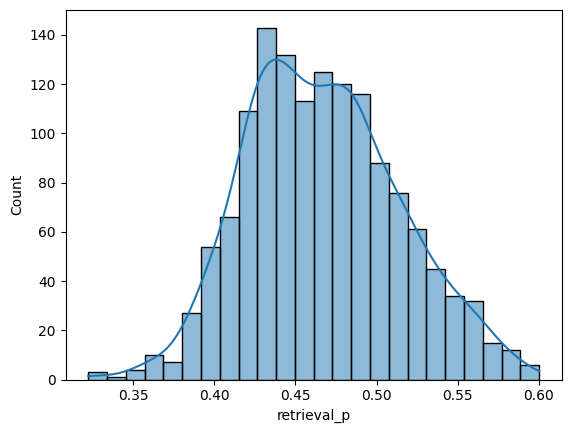

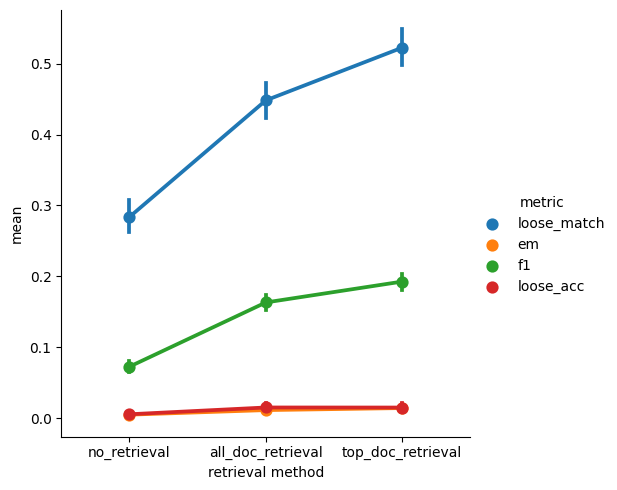

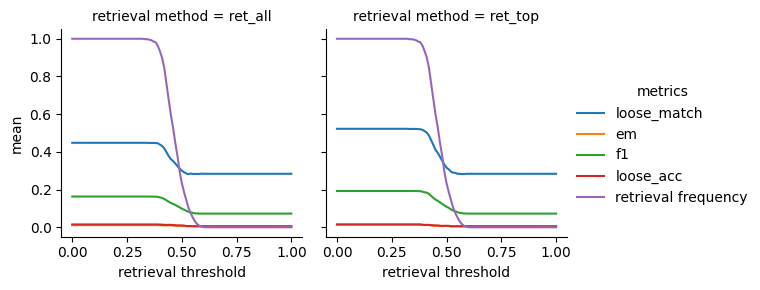

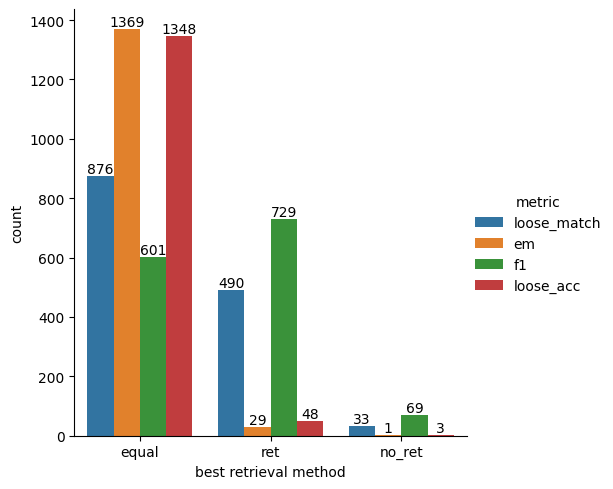

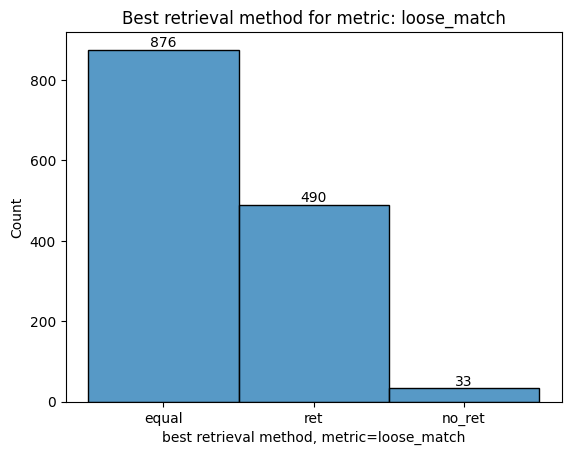

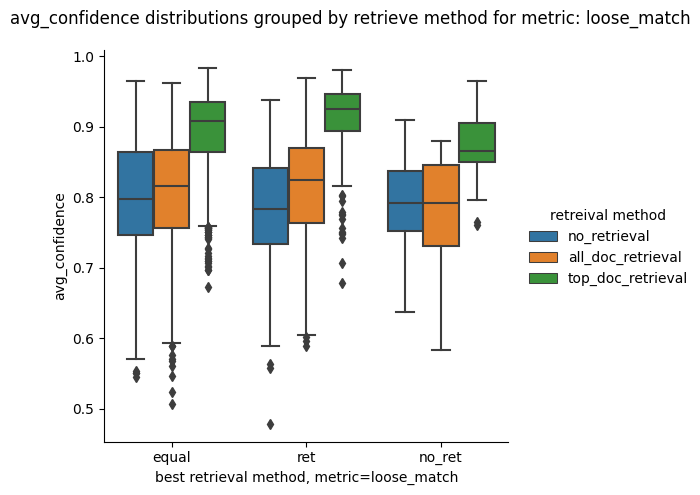

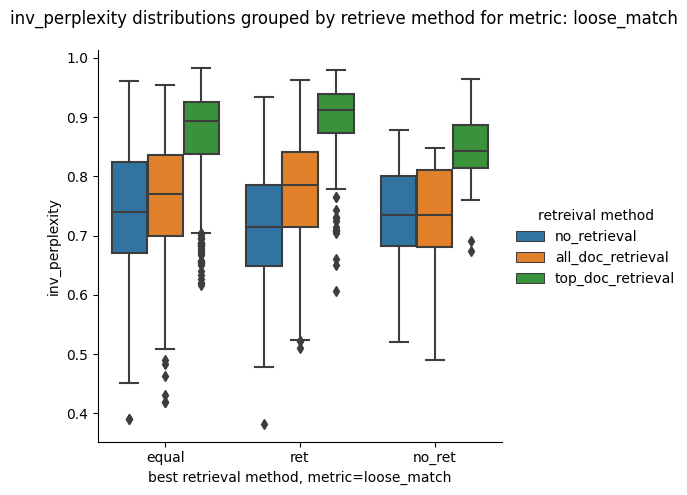

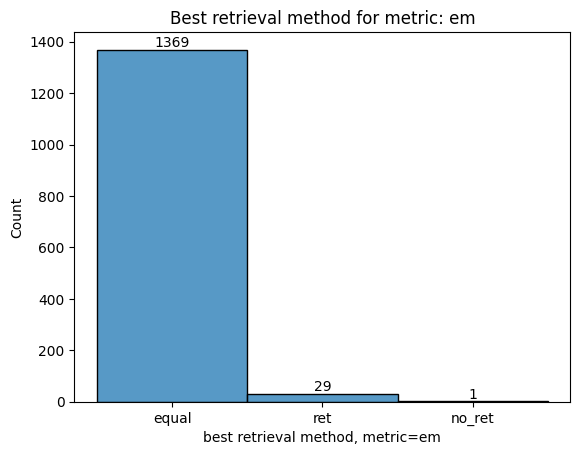

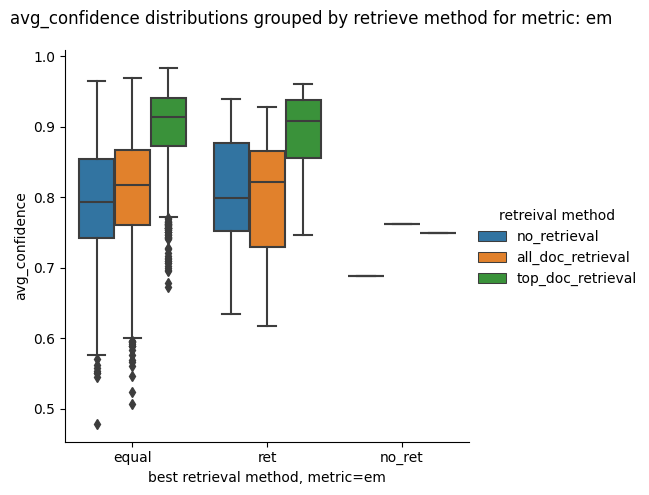

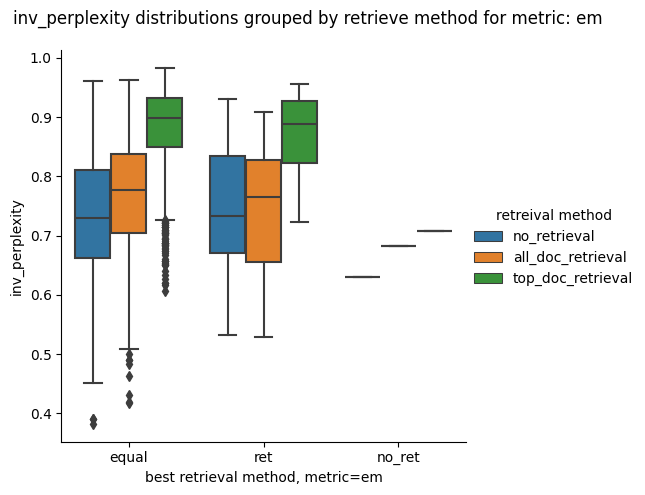

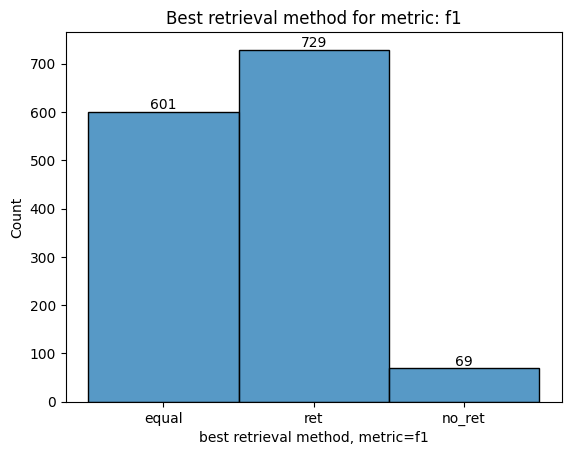

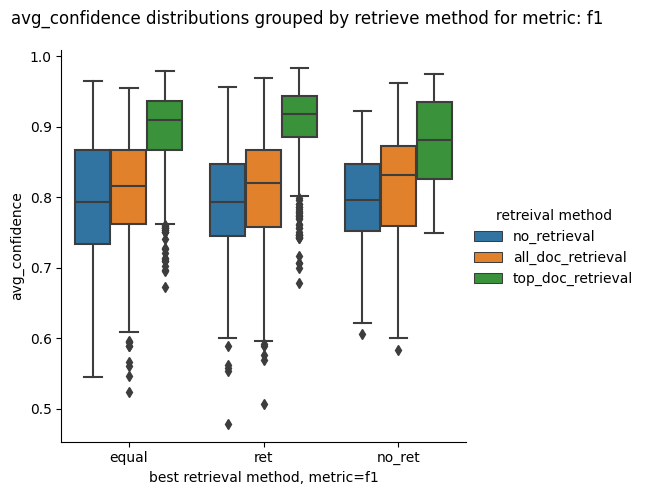

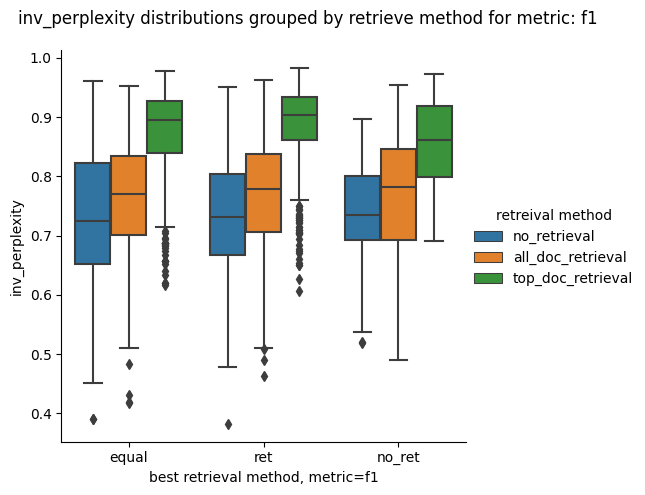

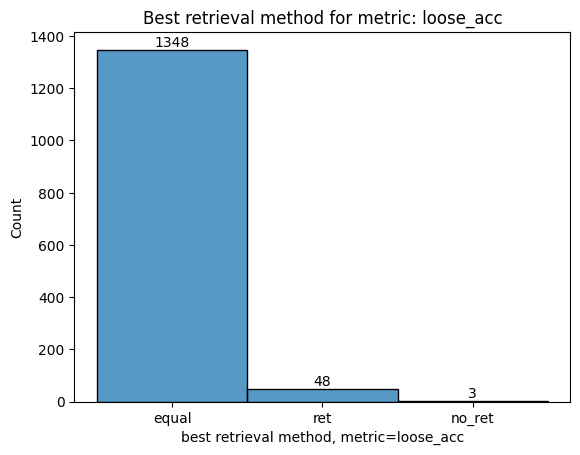

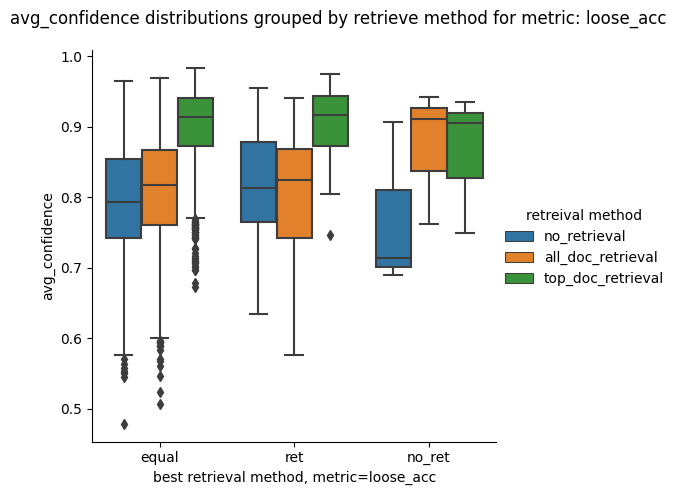

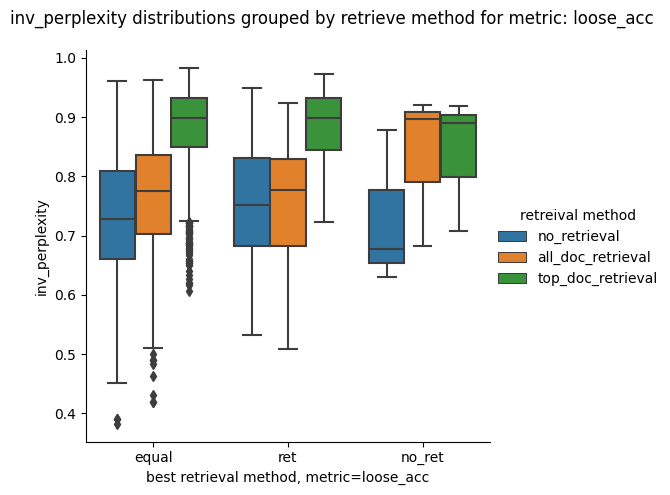

In [6]:
path = 'eval_res\selfrag-pqa_fullspan.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()

In [7]:
path = 'eval_res\selfrag-tqa_fullspan.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()

{'top_doc_retrieval_avg_confidence': [0.9230519460696193, 0.8902223733420003, 0.9091126170110542, 0.8982726317712728, 0.8633194867106028, 0.8486203661727805, 0.9311180722489758, 0.7659749442108992, 0.8962807926668948, 0.9171618528636538, 0.947004265241885, 0.9235727837205464, 0.9400036261457103, 0.8580245676245389, 0.922547220018075, 0.6973518952296666, 0.8586071555148924, 0.843981627713274, 0.906307618716579, 0.9304198005372489, 0.9356085549637773, 0.906444562082109, 0.9046002573888096, 0.8935571821593852, 0.9475646318875672, 0.9124865410317647, 0.9370163038554024, 0.942854009052361, 0.9280852221261261, 0.7833297375803944, 0.8991050874448564, 0.9458035223652197, 0.8944286136652472, 0.9374205477653281, 0.9715918263989475, 0.8392139167017992, 0.8809576878783558, 0.7736613557869528, 0.9320843330704027, 0.8919645764273693, 0.8296614902846533, 0.8637018264416748, 0.799936897273124, 0.7637150104399911, 0.8910049668968557, 0.9404994308416544, 0.7985650096845281, 0.9222363222559344, 0.9409870

In [ ]:
path = 'eval_res\selfrag-fullspan-arc.json'
pqa_analyzer = Analyzer(path)
# pqa_analyzer.draw_plots()



{'top_doc_retrieval_avg_confidence': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\22674\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


=== no_ret ===
Total number of samples: 987
loose_match: 0.7011144883485309
em: 0.7011144883485309
f1: 0.7011144883485309
loose_acc: 0.7011144883485309
=== ret_all ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 987
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0
loose_match: 0.5764944275582573
em: 0.5734549138804458
f1: 0.5743667679837893
loose_acc: 0.5734549138804458
=== ret_top ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 987
Number of samples with retrieval probability <= 0.2: 0
Retrieval frequency: 1.0
loose_match: 0.7244174265450861
em: 0.7244174265450861
f1: 0.7244174265450861
loose_acc: 0.7244174265450861


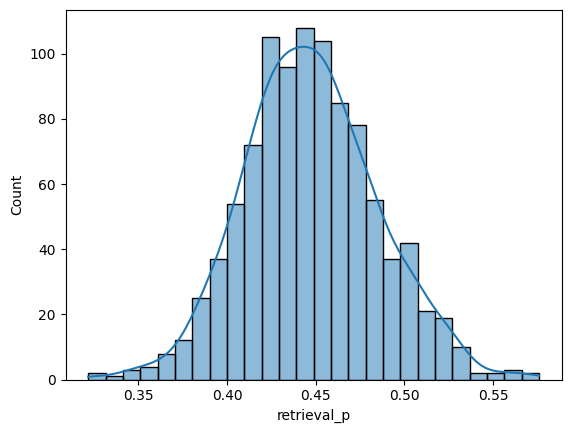

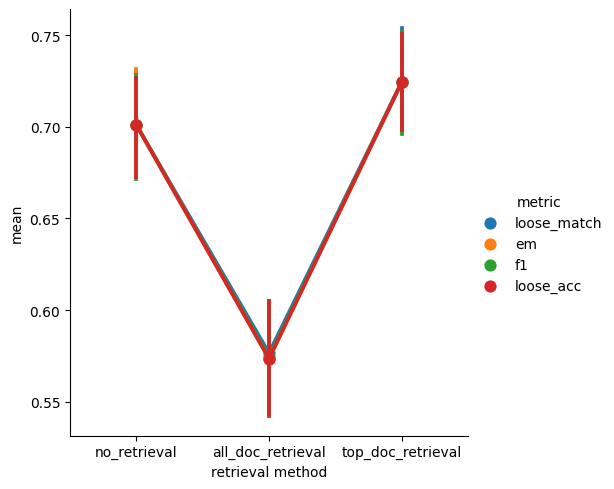

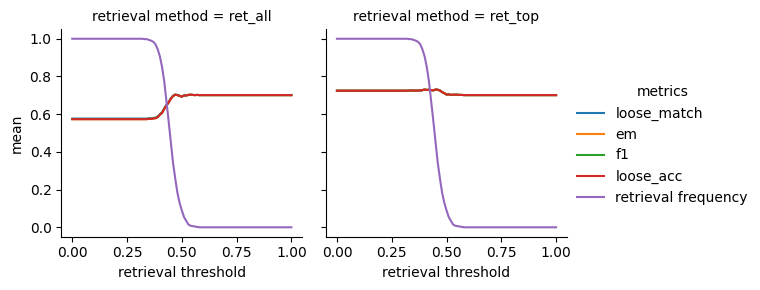

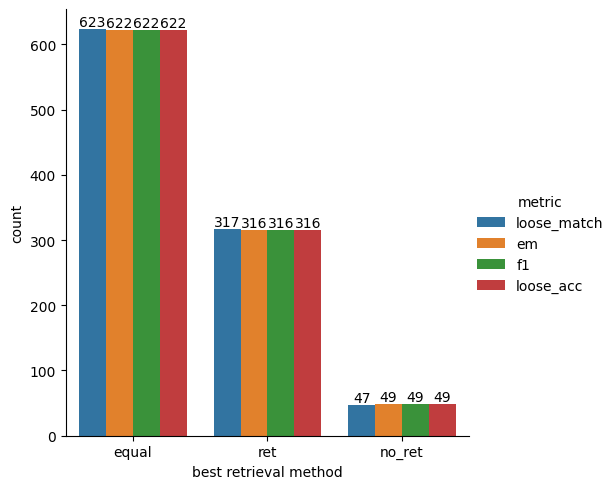

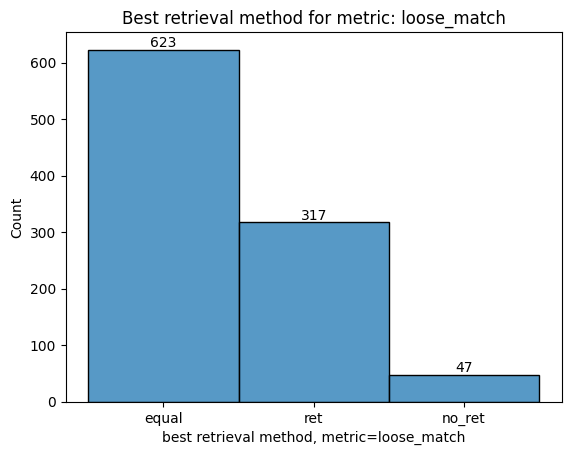

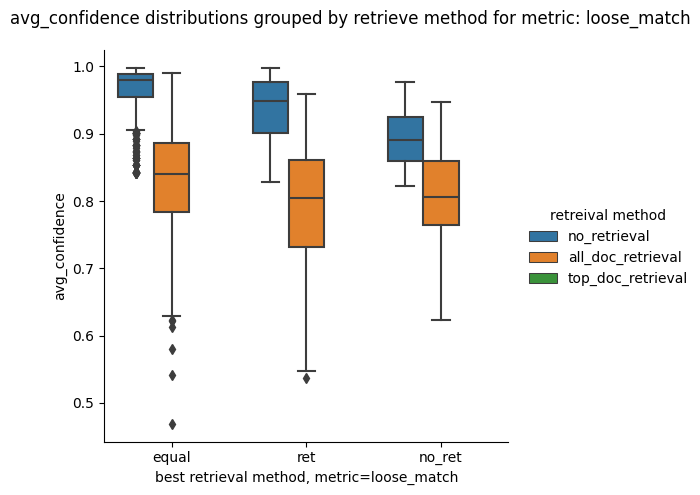

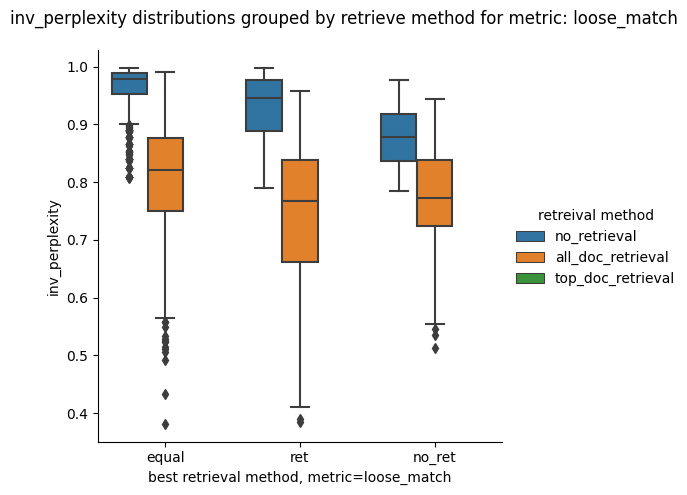

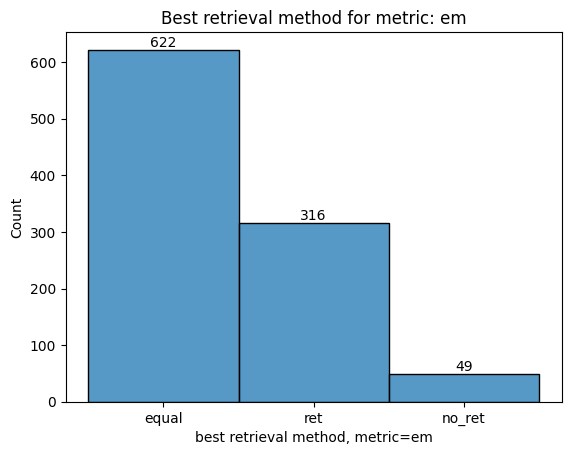

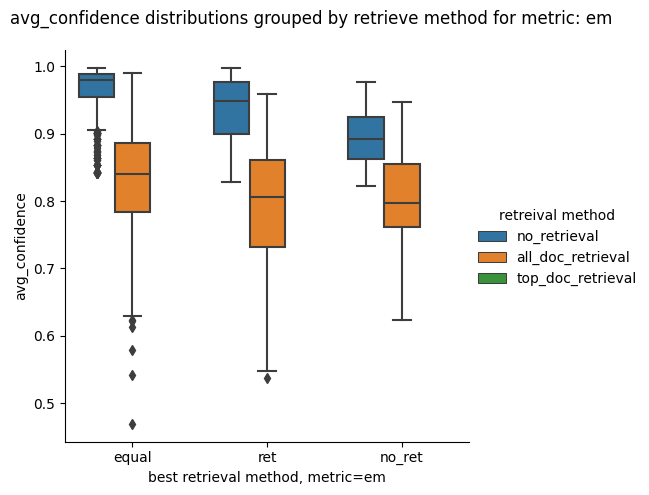

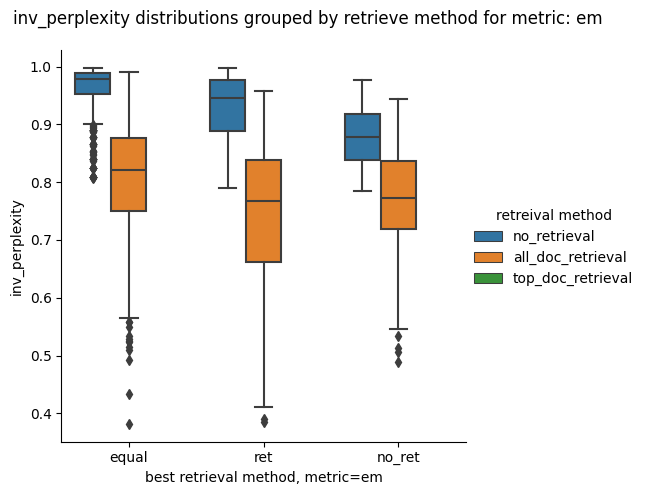

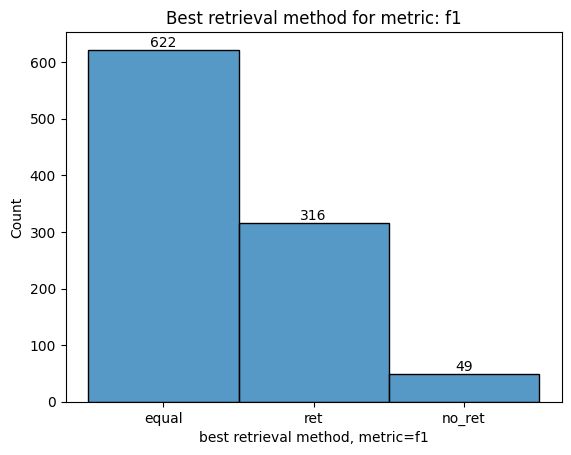

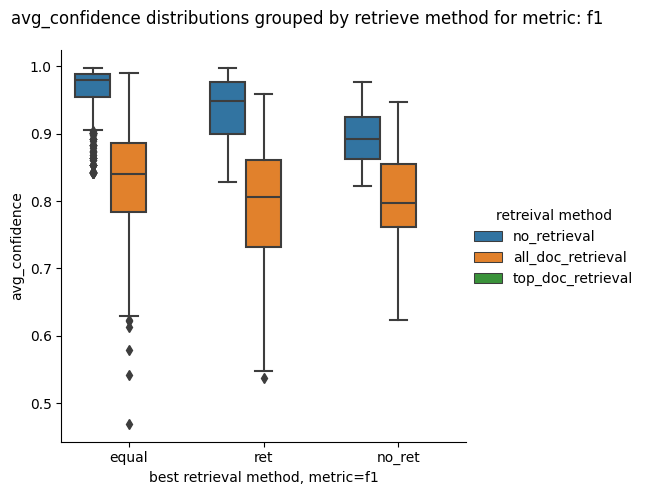

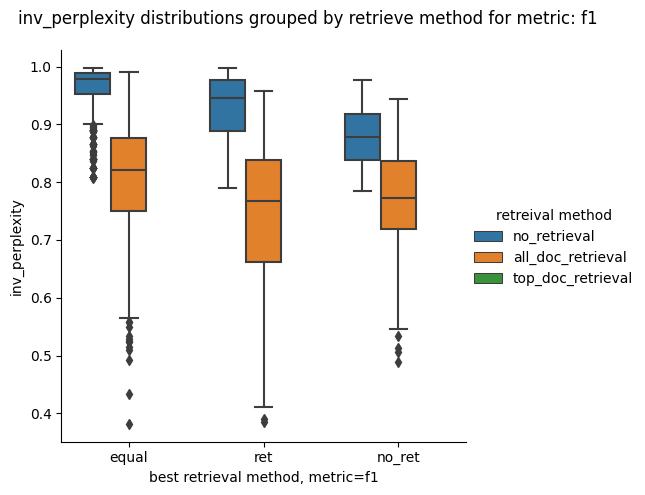

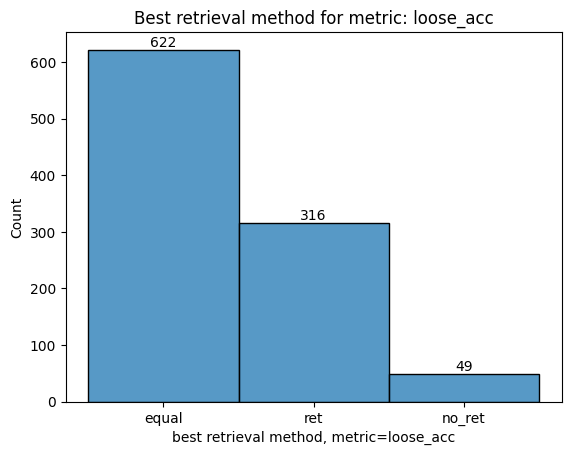

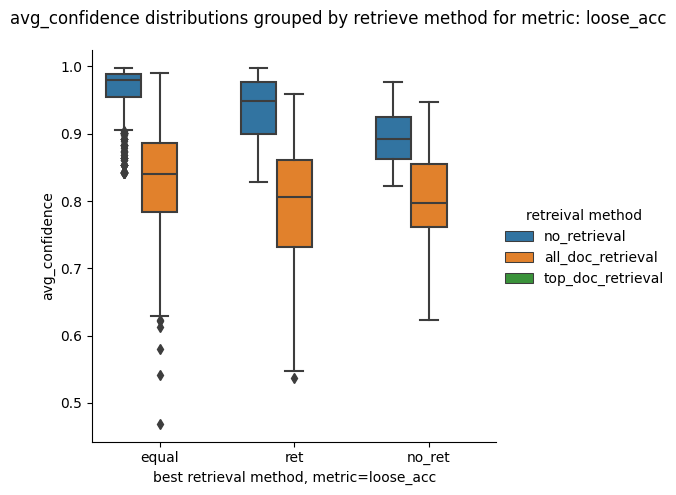

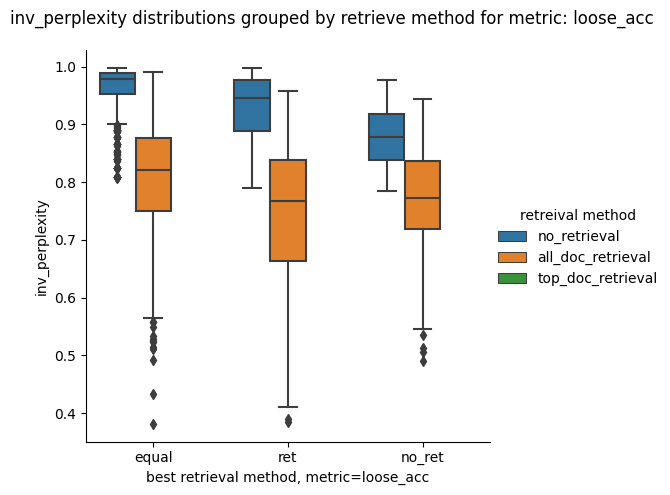

In [ ]:

path = 'eval_res\selfrag-fullspan-health.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()

=== no_ret ===
Total number of samples: 987
loose_match: 0.0
em: 0.7375886524822695
f1: 0.7381967363407372
loose_acc: 0.7378354218866676
=== ret_all ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 910
Number of samples with retrieval probability <= 0.2: 77
Retrieval frequency: 0.9219858156028369
loose_match_all_ret: 0.0
loose_match_adp_ret: 0.0
em_all_ret: 0.6312056737588653
em_adp_ret: 0.6210739614994935
f1_all_ret: 0.6312836100070143
f1_adp_ret: 0.6215080827309322
loose_acc_all_ret: 0.6312371387037702
loose_acc_adp_ret: 0.6212472127655315
=== ret_top ===
Threshold: 0.2
Total number of samples: 987
Number of samples with retrieval probability > 0.2: 910
Number of samples with retrieval probability <= 0.2: 77
Retrieval frequency: 0.9219858156028369
loose_match_all_ret: 0.0
loose_match_adp_ret: 0.0
em_all_ret: 0.6058763931104356
em_adp_ret: 0.5977710233029382
f1_all_ret: 0.606968872486368
f1_adp_ret: 0.5990447866798588
loose_acc_all_re

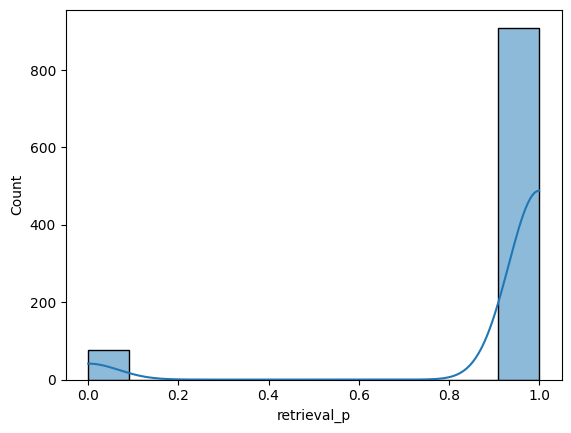

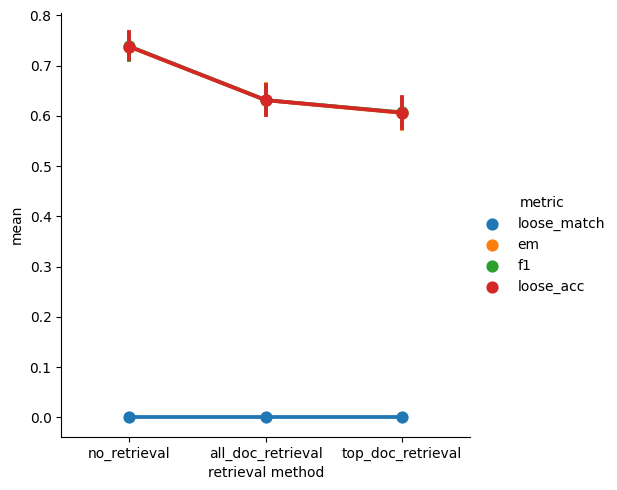

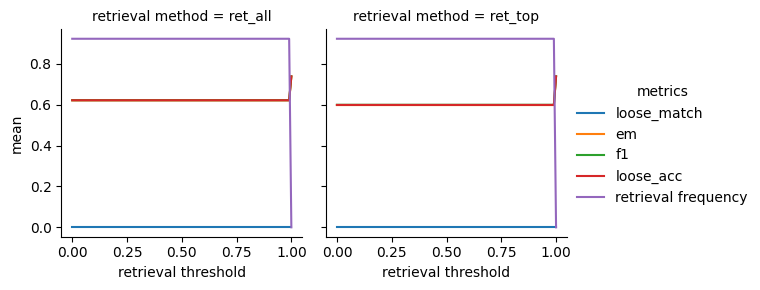

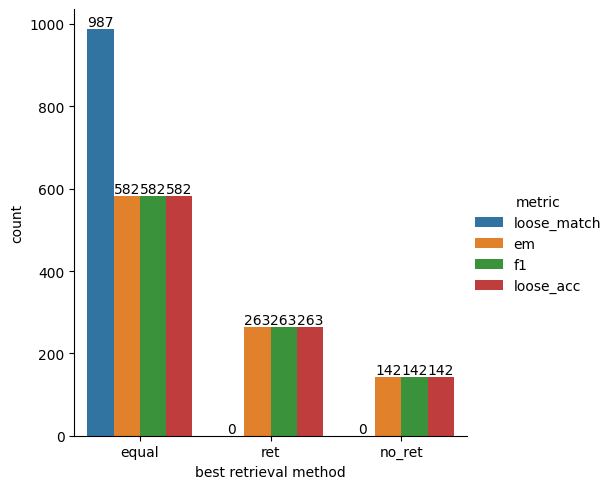

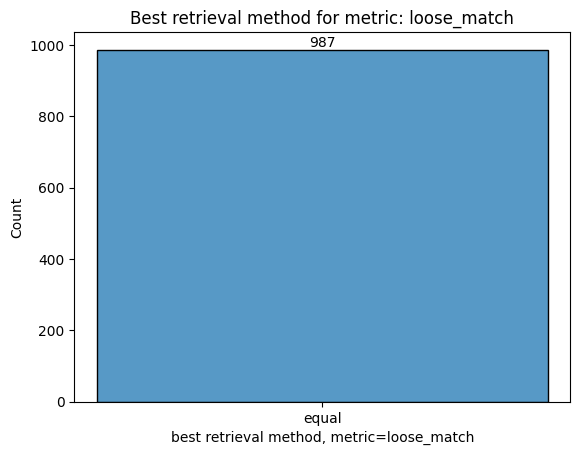

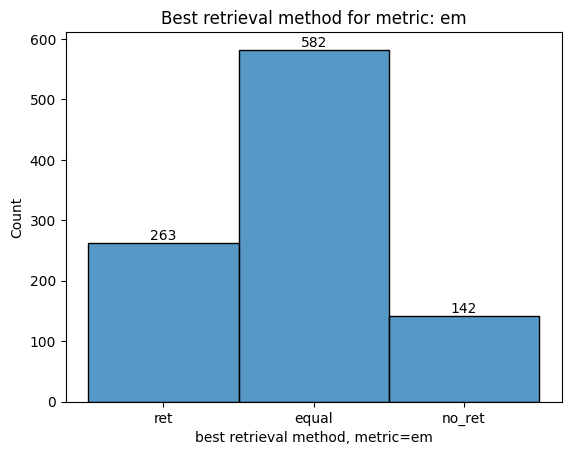

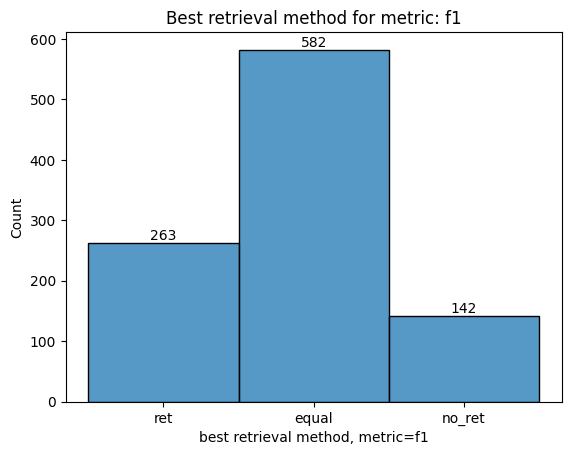

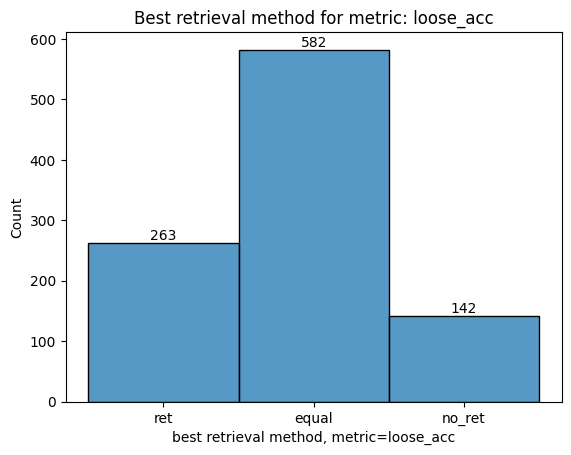

In [ ]:
path = r'eval_res\health_minqi.json'
pqa_analyzer = Analyzer(path)
pqa_analyzer.draw_plots()